<a href="https://colab.research.google.com/github/Bash-Code/Semi_supervised_GAN_DIGIT_RECOGNITION/blob/main/SGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SGAN handwritten Digit Recognition

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Lambda,Activation
from matplotlib import pyplot
from keras import backend
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import expand_dims

# Section 1 : Prepare the Data

in this section :
1. we load the MNIST dataset and
seperate our trainig and test data.
We performed reshape and normalization to Data to scale the pixel values to the range [-1,1].
then we encode the target categories using ontHot encoding

2. we perform data separation on training the data to take 100 labeled data as the problem defines and 59900 unlabeled Data




In [ ]:
(train_images, train_labels), (test_images,test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
train_images = expand_dims(train_images, axis=-1)
test_images = expand_dims(test_images, axis=-1)
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
# normalisation des images de [0,255] à [-1,1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

In [ ]:
#séparation du data set d'entrainement entre 100 données labélisée répartie de façon équilibrée entre 10 classes
num_classes = 10
num_images_per_class = 10

train_images_labeled_list= []
train_labels_list = []
labeled_images_idx = []

for i in range(num_classes):
  images_per_class = train_images[train_labels == i]
  indexes = np.where(train_labels == i)[0]
  random_choosing = np.random.choice(indexes,num_images_per_class,replace = False)

  train_images_labeled_list = train_images_labeled_list + [train_images[index] for index in random_choosing]
  train_labels_list = train_labels_list + [train_labels[index] for index in random_choosing]
  labeled_images_idx = labeled_images_idx + [index for index in random_choosing]

train_images_labeled , train_labels_sub= asarray(train_images_labeled_list), asarray(train_labels_list)



In [ ]:
train_images_labeled.shape

(100, 28, 28, 1)

In [ ]:
train_labels_sub.shape

(100,)

In [ ]:
len(labeled_images_idx)

100

In [ ]:
def display_images(images):
  for i in range(0,9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

In [ ]:
#ici on prend le reste des images du dataset comme non labélisés (on néglige les labels dans l'entrainement)
rest_of_images = np.delete(train_images,labeled_images_idx,axis=0)

In [ ]:
rest_of_labels = np.delete(train_labels,labeled_images_idx,axis=0)

In [ ]:
rest_of_images.shape

(59900, 28, 28, 1)

In [ ]:
rest_of_labels.shape

(59900,)

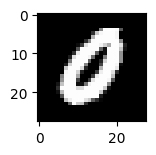

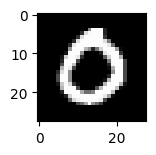

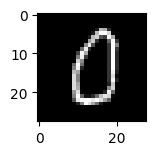

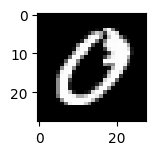

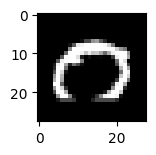

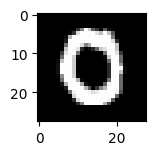

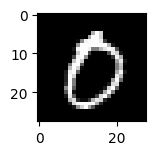

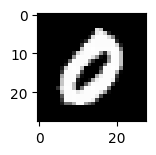

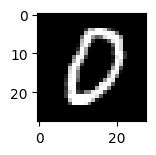

In [ ]:
display_images(train_images_labeled)

In [ ]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  # les images réelles sont labélisée par 1
  y = ones((n_samples, 1))
  return [X, labels], y


# Section 2 : Prepare the Architeture Models for Semi-supervised GAN

1. Discriminator
2. Discriminator Supervised
3. Discriminator Unsupervised
4. generator
5. GAN

In [ ]:
def Discriminator():
  in_image = Input(shape=(28,28,1))
  # les deux modèles supervisé et non supérvisé partagent les mêmes couches de convolution
  layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(layer)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(layer)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Flatten()(layer)
  layer = Dropout(0.4)(layer)
  #modèle supervisé
  supervised_output_layer = Dense(10, activation='softmax')(layer)
  supervised_model = Model(in_image, supervised_output_layer)
  supervised_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
  #modèle non-supervisé
  unsupervised_output_layer = Dense(1, activation='sigmoid')(layer)
  unsupervised_model = Model(in_image, unsupervised_output_layer)
  unsupervised_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  return unsupervised_model, supervised_model


In [ ]:
#modèle du générateur
def generator(latent_dim):
  in_lat = Input(shape=(latent_dim,))

  n_nodes = 128 * 7 * 7
  #on commence par une couche Dense pour représenté une version de l'image de base résolution
  layer = Dense(n_nodes)(in_lat)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Reshape((7, 7, 128))(layer)
  #les couches de transposition de convolution suivantes servent à effectuer un upscaling
  layer = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(layer)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(layer)
  layer = LeakyReLU(alpha=0.2)(layer)
  generator_output_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(layer)

  generator_model = Model(in_lat, generator_output_layer)
  return generator_model

In [ ]:
# ce modèle on superpose les modèles de du discriminateur non supervisé et du génrateur pour redirigé les images fake vers le discriminateur.
def gan(generator_model, unsupervised_model):
  unsupervised_model.trainable = False
  gan_output = unsupervised_model(generator_model.output)
  model = Model(generator_model.input, gan_output)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  z_input = randn(latent_dim * n_samples)
  z_input = z_input.reshape(n_samples, latent_dim)
  return z_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # on utilise la fonction d'avant pour générer un vecteur de points aléatoires de l'espace latent
  z_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict(z_input)
  # les labels des classes Fake est 0
  y = zeros((n_samples, 1))
  return images, y

In [ ]:
latent_dim = 100
n_epochs=10
n_batch = 100

## Section 4 : Train the model

In [ ]:
def train(generator_model, unsupervised_model, supervised_model, gan_model,latent_dim, n_epochs, n_batch):
  X, y = train_images_labeled , train_labels_sub
  print(X.shape, y.shape)
  batch_per_epoch = int(train_images.shape[0] / n_batch)
  n_steps = batch_per_epoch * n_epochs
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, batch_per_epoch, n_steps))

  supervised_loss_history, supervised_acc_history = [], []
  unsupervised_loss_real_history, unsupervised_loss_fake_history = [], []
  g_loss_history = []

  for i in range(n_steps):
    # Mise à jour du discriminateur supervisé avec un demi batch des données réelles labélisée
    [Xsup_real, ysup_real], _ = generate_real_samples([X, y], half_batch)
    supervised_loss, supervised_acc = supervised_model.train_on_batch(Xsup_real, ysup_real)
    supervised_loss_history.append(supervised_loss)
    supervised_acc_history.append(supervised_acc)

		# Mise à jour deu Discriminateur non supervisé sur un demi batch de données réelles non labélisée et un demi batch de donnée générée par G
    [X_real, _], y_real = generate_real_samples([rest_of_images,rest_of_labels], half_batch)
    unsupervised_loss1 = unsupervised_model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
    unsupervised_loss2 = unsupervised_model.train_on_batch(X_fake, y_fake)
    unsupervised_loss_real_history.append(unsupervised_loss1)
    unsupervised_loss_fake_history.append(unsupervised_loss2)

		# Mise à jour du générateur à travers le modéle GAN
    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    g_loss_history.append(g_loss)

		# Résumer de la loss sur ce batch des modéles supervisé non supervisé et du générateur.
    print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, supervised_loss, supervised_acc*100, unsupervised_loss1, unsupervised_loss2, g_loss))

    if (i+1) % (batch_per_epoch * 1) == 0:
      summarize_performance(i, generator_model, supervised_model, latent_dim)

  return supervised_loss_history, supervised_acc_history, unsupervised_loss_real_history, unsupervised_loss_fake_history, g_loss_history


la fonction suivante sert a calculer l'accuracy du modéle sur les données d'entrainement aprés pour l'itération entrée en paramétre de sauvegrader le modéle et de sauvegarder les images générées par le générateur à cette phase.

In [ ]:
def summarize_performance(step, g_model, c_model, latent_dim, n_samples=100):
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  X = (X + 1) / 2.0
  for i in range(100):
    pyplot.subplot(10, 10, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  filename1 = 'generated_plot_%04d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()

  X, y = train_images, train_labels
  _, acc = c_model.evaluate(X, y, verbose=0)
  print('Classifier Accuracy: %.3f%%' % (acc * 100))
  filename2 = 'g_model_%04d.h5' % (step+1)
  g_model.save(filename2)
  filename3 = 'c_model_%04d.h5' % (step+1)
  c_model.save(filename3)
  print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
unsupervised_discriminator, supervised_discriminator = Discriminator()
generator = generator(latent_dim)
gan = gan(generator,unsupervised_discriminator)


In [ ]:
supervised_loss_history, supervised_acc_history, unsupervised_loss_real_history, unsupervised_loss_fake_history, g_loss_history = train(generator,unsupervised_discriminator,supervised_discriminator,gan,latent_dim,n_epochs,n_batch)

# Section 5 : evaluate the model

In [ ]:
from numpy import expand_dims
from keras.models import load_model
from keras.datasets.mnist import load_data

In [ ]:
#test du modéle sur les données d'entraienement et de test
model = load_model('c_model_5400.h5')
_, train_accuracy = model.evaluate(train_images, train_labels, verbose=0)
print('Train Accuracy: %.3f%%' % (train_accuracy * 100))
_, test_accuracy = model.evaluate(test_images,test_labels)
print('Test Accuracy: %.3f%%' % (test_accuracy * 100))

In [ ]:
test_labels.shape

313/313 [==============================] - 1s 4ms/step


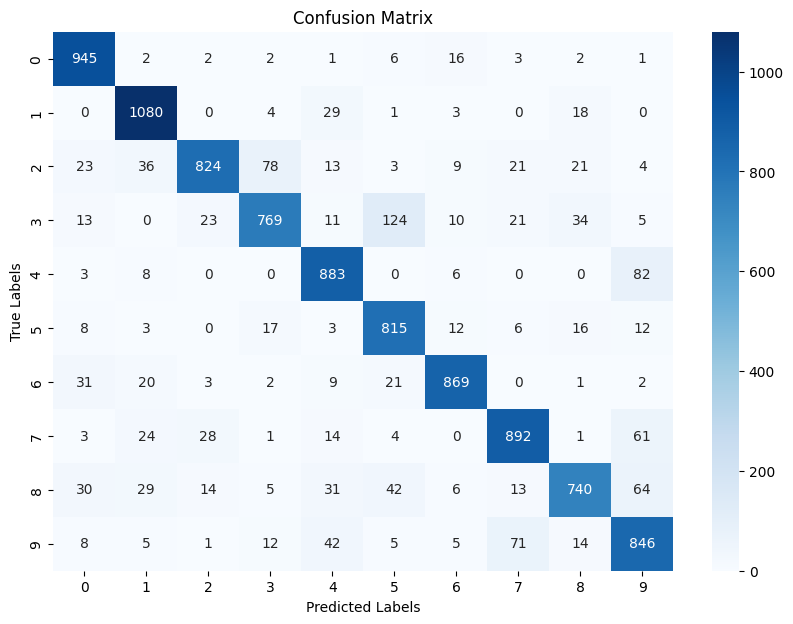

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# on affiche la matrice de confusion
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_labels
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()